In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import missingno as msno

from sklearn.preprocessing import QuantileTransformer,OneHotEncoder,KBinsDiscretizer,OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV,train_test_split
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from yellowbrick.model_selection import LearningCurve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score,make_scorer,
                             precision_recall_curve, auc, f1_score, fbeta_score, plot_confusion_matrix,roc_curve)
from sklearn.feature_selection import RFECV

pd.options.display.max_columns = 100

from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,
    DropCorrelatedFeatures
)

In [2]:
data = pd.read_csv("train.csv")
df = data.copy()

df.education = df.education.fillna("Bachelor's")
df.previous_year_rating = df.previous_year_rating.fillna(0.0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           41106 non-null  int64  
 1   department            41106 non-null  object 
 2   region                41106 non-null  object 
 3   education             41106 non-null  object 
 4   gender                41106 non-null  object 
 5   recruitment_channel   41106 non-null  object 
 6   no_of_trainings       41106 non-null  int64  
 7   age                   41106 non-null  int64  
 8   previous_year_rating  41106 non-null  float64
 9   length_of_service     41106 non-null  int64  
 10  KPIs_met >80%         41106 non-null  int64  
 11  awards_won?           41106 non-null  int64  
 12  avg_training_score    41106 non-null  int64  
 13  is_promoted           41106 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 4.4+ MB


In [3]:
orde = OrdinalEncoder(categories=[['Below Secondary', "Bachelor's", "Master's & above"]])
df[["education"]] = orde.fit_transform(df[["education"]])

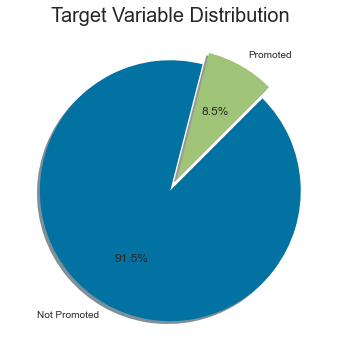

In [4]:
labels = ["Not Promoted","Promoted"]
plt.figure(figsize=(6,6))
plt.title("Target Variable Distribution",fontsize=20)
plt.pie(df.is_promoted.value_counts(),labels = labels, 
        counterclock=False, shadow=True, autopct='%1.1f%%', radius=1,explode=[0,0.1],startangle=45)
plt.show()

In [5]:
df.gender.unique()

array(['m', 'f'], dtype=object)

In [6]:
manu_map = {"m" : 1,
            "f" : 0}

df.gender = df.gender.map(manu_map)

In [8]:
df_cat_dummy = pd.get_dummies(df[["department","region","recruitment_channel"]], drop_first = True) # drops one dummy
df_cat_dummy

,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,recruitment_channel_referred,recruitment_channel_sourcing
0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41102,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41103,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41104,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
df.drop(columns=["department","region","recruitment_channel"],inplace=True)
df = pd.concat([df,df_cat_dummy],axis=1)
df

,employee_id,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,recruitment_channel_referred,recruitment_channel_sourcing
0,16184,1.0,1,1,36,4.0,4,1,0,51,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37446,1.0,1,1,51,4.0,3,1,0,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,36672,2.0,1,2,52,3.0,16,0,0,59,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,25362,1.0,1,2,26,3.0,5,0,0,82,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21445,1.0,1,1,29,2.0,6,0,0,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,65196,1.0,1,1,36,1.0,8,0,0,49,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41102,59173,2.0,1,1,33,4.0,3,0,0,84,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41103,32947,2.0,1,1,50,3.0,7,1,0,46,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41104,63163,1.0,0,1,30,5.0,4,0,1,79,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
df.drop("employee_id",axis=1,inplace=True)

In [11]:
def print_results(headline, true_value, pred, probs):
    scores=[]
    CM = confusion_matrix(true_value, pred)
    scores.append(headline)
    scores.append(accuracy_score(true_value, pred))
    scores.append(int(CM[1,1]))
    scores.append(int(CM[0,1]))
    scores.append(int(CM[0][0]))
    scores.append(int(CM[1][0]))
    scores.append(precision_score(true_value, pred))
    scores.append(recall_score(true_value, pred))
    scores.append(roc_auc_score(true_value, probs))
    p, r, _ = precision_recall_curve(true_value, probs)
    scores.append(auc(r,p))
    scores.append(f1_score(true_value, pred,average="macro"))
    scores.append(fbeta_score(true_value, pred, beta=2)) 
    return scores
score_names = ['method','accuracy','TP','FP','TN','FN','precision','recall','roc_auc','pr_auc','f1_macro', 'f2']
modelcomparison = pd.DataFrame(data=np.zeros(shape=(0,12)), columns = score_names)

In [12]:
for_scale = []
for i in df.columns:
    if df[i].nunique() > 30:
        for_scale.append(i)
        
for_scale

['age', 'length_of_service', 'avg_training_score']

In [13]:
scaler = QuantileTransformer(output_distribution='normal')
df[['age', 'length_of_service', 'avg_training_score']] = scaler.fit_transform(df[['age', 'length_of_service', 'avg_training_score']])

In [14]:
df

,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,recruitment_channel_referred,recruitment_channel_sourcing
0,1.0,1,1,0.374936,4.0,-0.270485,1,0,-0.703922,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,1,1,1.654145,4.0,-0.618059,1,0,0.307111,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2.0,1,2,1.727466,3.0,1.780005,0,0,-0.119468,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,1,2,-1.442543,3.0,0.021329,0,0,1.118711,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,1,1,-0.734798,2.0,0.267884,0,0,-0.858910,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,1.0,1,1,0.374936,1.0,0.764710,0,0,-1.055293,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41102,2.0,1,1,-0.028859,4.0,-0.618059,0,0,1.368450,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41103,2.0,1,1,1.579968,3.0,0.524976,1,0,-1.824556,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41104,1.0,0,1,-0.536531,5.0,-0.270485,0,1,0.833781,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# Model with All Features

In [15]:
train, test = train_test_split(df, test_size=0.30, random_state=42, stratify=df.is_promoted)

y_train = train.is_promoted
X_train = train.drop('is_promoted', axis=1)
y_test = test.is_promoted
X_test = test.drop('is_promoted', axis=1)

pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2,5,7,10,20,30]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid1 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model1 = grid1.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/6] END ......classifier__max_depth=2;, score=0.687 total time=  20.1s
[CV 2/2; 1/6] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/6] END ......classifier__max_depth=2

In [17]:
pred_probs = model1.predict_proba(X_test)[:,1]
scores = print_results('Model-1', y_test, model1.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.81252,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554


In [27]:
model1.best_params_

{'classifier__max_depth': 2}

# Feature Selection With BASICS

In [30]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

In [31]:
constant = DropConstantFeatures(tol=1)
constant.fit(X_train_1)
constant.features_to_drop_

[]

In [32]:
quasi_constant = DropConstantFeatures(tol=0.998)
quasi_constant.fit(X_train_1)
quasi_constant.features_to_drop_

['region_region_18']

In [33]:
X_train_1 = quasi_constant.transform(X_train_1)
X_test_1 = quasi_constant.transform(X_test_1)

In [34]:
duplicates = DropDuplicateFeatures()
duplicates.fit(X_train_1)
duplicates.features_to_drop_

set()

In [35]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid2 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model2 = grid2.fit(X_train_1, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.687 total time=  20.2s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [36]:
pred_probs = model2.predict_proba(X_test_1)[:,1]
scores = print_results('Model-2-Basics', y_test, model2.predict(X_test_1), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554


# Feature Selection - Correlation

In [37]:
X_train_2 = X_train_1.copy()
X_test_2 = X_test_1.copy()

In [43]:
correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
correlated.fit(X_train_2)
correlated.features_to_drop_

set()

In [41]:
smart_corr = SmartCorrelatedSelection(
    variables=None, # examines all variables
    method="pearson", # the correlation method
    threshold=0.7, # the correlation coefficient threshold
    missing_values="ignore",
    selection_method="model_performance", 
    scoring = "f1_macro",
    estimator=LGBMClassifier(random_state=42,
                            boosting_type = "dart",
                            class_weight = {0:0.90 , 1:0.10},
                            n_estimators = 1500,
                            subsample = 0.6,
                            num_leaves = 30,
                            min_data_in_leaf = 30,
                            max_bin = 500000,
                            learning_rate = 0.03,
                            lambda_l2 = 5,
                            lambda_l1 = 0.1,
                            colsample_bytree = 0.5))

smart_corr.fit(X_train_2, y_train)

SmartCorrelatedSelection(estimator=LGBMClassifier(boosting_type='dart',
                                                  class_weight={0: 0.9, 1: 0.1},
                                                  colsample_bytree=0.5,
                                                  lambda_l1=0.1, lambda_l2=5,
                                                  learning_rate=0.03,
                                                  max_bin=500000,
                                                  min_data_in_leaf=30,
                                                  n_estimators=1500,
                                                  num_leaves=30,
                                                  random_state=42,
                                                  subsample=0.6),
                         scoring='f1_macro',
                         selection_method='model_performance', threshold=0.7)

In [42]:
smart_corr.features_to_drop_

[]

In [44]:
smart_corr = SmartCorrelatedSelection(
    variables=None, # examines all variables
    method="pearson", # the correlation method
    threshold=0.7, # the correlation coefficient threshold
    missing_values="ignore",
    selection_method="variance", 
    scoring = "f1_macro",
    estimator=LGBMClassifier(random_state=42,
                            boosting_type = "dart",
                            class_weight = {0:0.90 , 1:0.10},
                            n_estimators = 1500,
                            subsample = 0.6,
                            num_leaves = 30,
                            min_data_in_leaf = 30,
                            max_bin = 500000,
                            learning_rate = 0.03,
                            lambda_l2 = 5,
                            lambda_l1 = 0.1,
                            colsample_bytree = 0.5))

smart_corr.fit(X_train_2, y_train)

SmartCorrelatedSelection(estimator=LGBMClassifier(boosting_type='dart',
                                                  class_weight={0: 0.9, 1: 0.1},
                                                  colsample_bytree=0.5,
                                                  lambda_l1=0.1, lambda_l2=5,
                                                  learning_rate=0.03,
                                                  max_bin=500000,
                                                  min_data_in_leaf=30,
                                                  n_estimators=1500,
                                                  num_leaves=30,
                                                  random_state=42,
                                                  subsample=0.6),
                         scoring='f1_macro', selection_method='variance',
                         threshold=0.7)

In [45]:
smart_corr.features_to_drop_

[]

# ANOVA

In [46]:
from sklearn.feature_selection import (
    VarianceThreshold,
    f_classif,
    SelectKBest,
)

In [49]:
sel_ = SelectKBest(f_classif, k=20).fit(X_train_2, y_train)

# capture selected feature names
features_to_keep = X_train_2.columns[sel_.get_support()]

# or
features_to_keep = sel_.get_feature_names_out()

# ============

# select features
X_train_anova = sel_.transform(X_train_2)
X_test_anova = sel_.transform(X_test_2)

# numpy array to dataframe
X_train_anova = pd.DataFrame(X_train_anova)
X_train_anova.columns = features_to_keep

X_test_anova = pd.DataFrame(X_test_anova)
X_test_anova.columns = features_to_keep

X_train_anova.shape, X_test_anova.shape

((28774, 20), (12332, 20))

In [50]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid3 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model3 = grid3.fit(X_train_anova, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.559 total time=  20.4s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;, score=0.537 total time=  29.5s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ign

In [52]:
pred_probs = model3.predict_proba(X_test_anova)[:,1]
scores = print_results('Model-3-Anova', y_test, model3.predict(X_test_anova), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675


# Univariate Score

In [54]:
roc_values = []

for feature in X_train_1.columns:

    clf =LGBMClassifier(random_state=42,
                        boosting_type = "dart",
                        class_weight = {0:0.90 , 1:0.10},
                        n_estimators = 1500,
                        subsample = 0.6,
                        num_leaves = 30,
                        min_data_in_leaf = 30,
                        max_bin = 500000,
                        learning_rate = 0.03,
                        lambda_l2 = 5,
                        lambda_l1 = 0.1,
                        colsample_bytree = 0.5)
    clf.fit(X_train_1[feature].fillna(0).to_frame(), y_train)

    y_scored = clf.predict_proba(X_test_1[feature].to_frame())

    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

Text(0, 0.5, 'ROC-AUC')

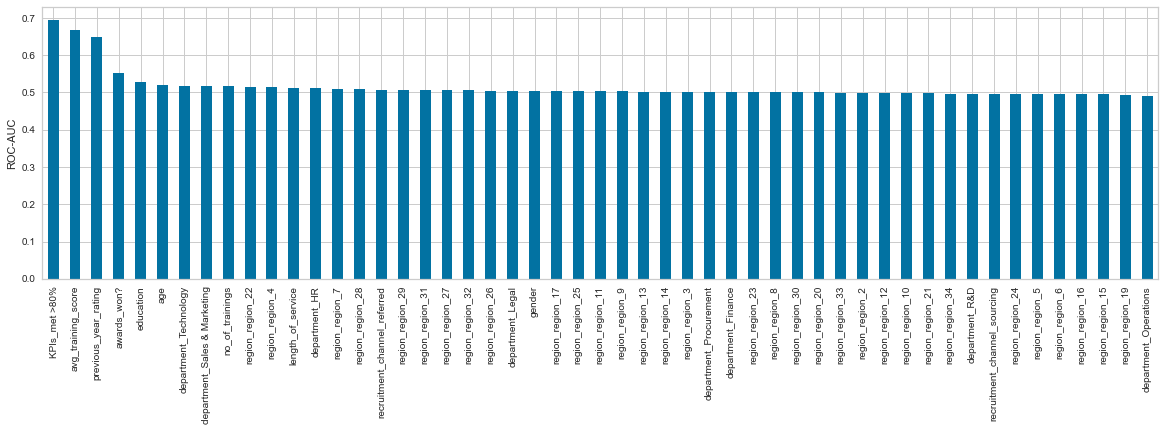

In [55]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train_1.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('ROC-AUC')

In [56]:
len(roc_values[roc_values > 0.5])

33

In [57]:
selected_features = roc_values[roc_values > 0.5].index

selected_features

Index(['education', 'gender', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'department_Finance', 'department_HR',
       'department_Legal', 'department_Procurement',
       'department_Sales & Marketing', 'department_Technology',
       'region_region_11', 'region_region_13', 'region_region_14',
       'region_region_17', 'region_region_22', 'region_region_23',
       'region_region_25', 'region_region_26', 'region_region_27',
       'region_region_28', 'region_region_29', 'region_region_3',
       'region_region_31', 'region_region_32', 'region_region_4',
       'region_region_7', 'region_region_9', 'recruitment_channel_referred'],
      dtype='object')

In [58]:
X_train_3 = X_train_1[selected_features]
X_test_3 = X_test_1[selected_features]

X_train_3.shape, X_test_3.shape

((28774, 33), (12332, 33))

In [59]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_3, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.549 total time=  21.6s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [60]:
pred_probs = model4.predict_proba(X_test_3)[:,1]
scores = print_results('Model-4-Univariate', y_test, model4.predict(X_test_3), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324


In [61]:
from feature_engine.selection import SelectBySingleFeaturePerformance

In [62]:
clf =LGBMClassifier(random_state=42,
                    boosting_type = "dart",
                    class_weight = {0:0.90 , 1:0.10},
                    n_estimators = 1500,
                    subsample = 0.6,
                    num_leaves = 30,
                    min_data_in_leaf = 30,
                    max_bin = 500000,
                    learning_rate = 0.03,
                    lambda_l2 = 5,
                    lambda_l1 = 0.1,
                    colsample_bytree = 0.5)

sel = SelectBySingleFeaturePerformance(
    variables=None,
    estimator=clf,
    scoring="f1_macro",
    cv=3,
    threshold=0.5,
)

sel.fit(X_train_1, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

SelectBySingleFeaturePerformance(estimator=LGBMClassifier(boosting_type='dart',
                                                          class_weight={0: 0.9,
                                                                        1: 0.1},
                                                          colsample_bytree=0.5,
                                                          lambda_l1=0.1,
                                                          lambda_l2=5,
                                                          learning_rate=0.03,
                                                          max_bin=500000,
                                                          min_data_in_leaf=30,
                                                          n_estimators=1500,
                                                          num_leaves=30,
                                                          random_state=42,
                                                          subsample=0.6),
     

In [63]:
X_train_4 = sel.transform(X_train_1)
X_test_4 = sel.transform(X_test_1)

pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_4, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.560 total time=  15.7s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [64]:
pred_probs = model4.predict_proba(X_test_4)[:,1]
scores = print_results('Model-4-Univariate-FE', y_test, model4.predict(X_test_4), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492


In [67]:
df1 = data.copy()
df1.education = df1.education.fillna("Bachelor's")
df1.previous_year_rating = df1.previous_year_rating.fillna(0.0)

In [65]:
from feature_engine.selection import SelectByTargetMeanPerformance

In [68]:
train, test = train_test_split(df1, test_size=0.30, random_state=42, stratify=df1.is_promoted)

y_train = train.is_promoted
X_train = train.drop('is_promoted', axis=1)
y_test = test.is_promoted
X_test = test.drop('is_promoted', axis=1)

In [75]:
sel = SelectByTargetMeanPerformance(
    variables=None, # automatically finds categorical and numerical variables
    scoring="roc_auc", # the metric to evaluate performance
    threshold=0.6, # the threshold for feature selection, 
    bins=10, # the number of intervals to discretise the numerical variables
    strategy="equal_frequency", # whether the intervals should be of equal size or equal number of observations
    cv=2,# cross validation
    regression=False, # whether this is regression or classification
)

sel.fit(X_train, y_train)

SelectByTargetMeanPerformance(bins=10, cv=2, strategy='equal_frequency',
                              threshold=0.6)

In [76]:
sel.feature_performance_

{'employee_id': 0.5082256457918217,
 'department': 0.5448234719619227,
 'region': 0.5798789622599805,
 'education': 0.5204474116294757,
 'gender': 0.5092081882281491,
 'recruitment_channel': 0.5070200469244032,
 'no_of_trainings': 0.5054824146409617,
 'age': 0.530905199642116,
 'previous_year_rating': 0.6439120002784213,
 'length_of_service': 0.4997772831217078,
 'KPIs_met >80%': 0.5,
 'awards_won?': 0.5,
 'avg_training_score': 0.6610703999065238}

In [78]:
X_train_4 = X_train[["avg_training_score","previous_year_rating"]]
X_test_4 = X_test[["avg_training_score","previous_year_rating"]]

pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_4, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.452 total time=  20.4s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [79]:
pred_probs = model4.predict_proba(X_test_4)[:,1]
scores = print_results('Model-5-Bins+TargetMean', y_test, model4.predict(X_test_4), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013


In [110]:
def mean_encoding(df_train, df_test, categorical_vars):
    
    # temporary copy of the original dataframes
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()
    
    # iterate over each variable
    for col in categorical_vars:
        
        # make a dictionary of categories, target-mean pairs
        target_mean_dict = df_train.groupby([col])['is_promoted'].mean().to_dict()
        
        # replace the categories by the mean of the target
        df_train_temp[col] = df_train[col].map(target_mean_dict)
        df_test_temp[col] = df_test[col].map(target_mean_dict)
    

    
    # return  remapped datasets
    return df_train_temp, df_test_temp

In [90]:
df1 = df1.drop("employee_id",axis=1)

In [91]:
categorical_vars = df1[["department","region","education","gender","recruitment_channel"]]

In [92]:
train, test = train_test_split(df1, test_size=0.30, random_state=42, stratify=df1.is_promoted)

In [93]:
X_train_enc, X_test_enc = mean_encoding(train, test, categorical_vars)

X_train_enc.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
9164,0.091104,0.072316,0.080108,0.083140,0.083469,2,37,4.0,5,0,0,86,0
6838,0.071016,0.042000,0.080108,0.090015,0.083469,1,29,4.0,4,0,0,53,0
39563,0.091104,0.113479,0.080108,0.083140,0.086554,3,28,3.0,2,1,0,89,0
3942,0.071016,0.072316,0.080108,0.083140,0.086554,1,36,1.0,7,0,0,49,0
26377,0.090189,0.079052,0.080108,0.090015,0.086554,1,58,3.0,28,1,0,58,0


In [95]:
scaler = QuantileTransformer(output_distribution='normal')
df1[['age', 'length_of_service', 'avg_training_score']] = scaler.fit_transform(df1[['age', 'length_of_service', 'avg_training_score']])

In [96]:
X_train_enc.drop(['is_promoted'], axis=1, inplace=True)
X_test_enc.drop(['is_promoted'], axis=1, inplace=True)

In [97]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_enc, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.651 total time=  23.1s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [98]:
pred_probs = model4.predict_proba(X_test_enc)[:,1]
scores = print_results('Model-6-TargetMean', y_test, model4.predict(X_test_enc), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172


In [118]:
#######

In [146]:
dfx = data.copy()

In [147]:
dfx.education = dfx.education.fillna("Bachelor's")
dfx.previous_year_rating = dfx.previous_year_rating.fillna(0.0)

In [148]:
train, test = train_test_split(dfx, test_size=0.30, random_state=42, stratify=dfx.is_promoted)
X_train_enc, X_test_enc = mean_encoding(train, test, categorical_vars)

In [149]:
X_train_enc

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
9164,11994,0.091104,0.072316,0.080108,0.083140,0.083469,2,37,4.0,5,0,0,86,0
6838,14446,0.071016,0.042000,0.080108,0.090015,0.083469,1,29,4.0,4,0,0,53,0
39563,33875,0.091104,0.113479,0.080108,0.083140,0.086554,3,28,3.0,2,1,0,89,0
3942,8812,0.071016,0.072316,0.080108,0.083140,0.086554,1,36,1.0,7,0,0,49,0
26377,43158,0.090189,0.079052,0.080108,0.090015,0.086554,1,58,3.0,28,1,0,58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,27759,0.088083,0.090147,0.080108,0.083140,0.083469,2,26,5.0,2,1,0,59,0
29174,22417,0.090189,0.113479,0.098499,0.090015,0.086554,2,31,4.0,1,0,0,58,0
2302,47623,0.071016,0.053295,0.080108,0.083140,0.083469,2,25,0.0,1,0,0,45,0
14021,65252,0.099055,0.123953,0.098499,0.083140,0.083469,2,40,3.0,14,0,0,67,0


In [150]:
# train
X_train_enc['age_binned'], intervals = pd.qcut( X_train_enc['age'],
                                            q=5,
                                            labels=False,
                                            retbins=True,
                                            precision=3,
                                            duplicates='drop')

X_train_enc

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,age_binned
9164,11994,0.091104,0.072316,0.080108,0.083140,0.083469,2,37,4.0,5,0,0,86,0,3
6838,14446,0.071016,0.042000,0.080108,0.090015,0.083469,1,29,4.0,4,0,0,53,0,1
39563,33875,0.091104,0.113479,0.080108,0.083140,0.086554,3,28,3.0,2,1,0,89,0,0
3942,8812,0.071016,0.072316,0.080108,0.083140,0.086554,1,36,1.0,7,0,0,49,0,3
26377,43158,0.090189,0.079052,0.080108,0.090015,0.086554,1,58,3.0,28,1,0,58,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,27759,0.088083,0.090147,0.080108,0.083140,0.083469,2,26,5.0,2,1,0,59,0,0
29174,22417,0.090189,0.113479,0.098499,0.090015,0.086554,2,31,4.0,1,0,0,58,0,1
2302,47623,0.071016,0.053295,0.080108,0.083140,0.083469,2,25,0.0,1,0,0,45,0,0
14021,65252,0.099055,0.123953,0.098499,0.083140,0.083469,2,40,3.0,14,0,0,67,0,3


In [151]:
# test
X_test_enc['age_binned'] = pd.cut(x = X_test_enc['age'], bins=intervals, labels=False)

In [152]:
X_test_enc.isnull().sum()

employee_id              0
department               0
region                   0
education                0
gender                   0
recruitment_channel      0
no_of_trainings          0
age                      0
previous_year_rating     0
length_of_service        0
KPIs_met >80%            0
awards_won?              0
avg_training_score       0
is_promoted              0
age_binned              19
dtype: int64

In [153]:
X_train_enc['length_of_service_binned'], intervals = pd.qcut( X_train_enc['length_of_service'],
                                                            q=5,
                                                            labels=False,
                                                            retbins=True,
                                                            precision=3,
                                                            duplicates='drop')

X_test_enc['length_of_service_binned'] = pd.cut(x = X_test_enc['length_of_service'], bins=intervals, labels=False)


X_train_enc['avg_training_score_binned'], intervals = pd.qcut( X_train_enc['avg_training_score'],
                                                            q=5,
                                                            labels=False,
                                                            retbins=True,
                                                            precision=3,
                                                            duplicates='drop')

X_test_enc['avg_training_score_binned'] = pd.cut(x = X_test_enc['avg_training_score'], bins=intervals, labels=False)

In [154]:
X_test_enc = X_test_enc.fillna(0)

In [155]:
X_test_enc2 = X_test_enc.copy()
X_train_enc2 = X_train_enc.copy()
binned_vars = ['age_binned', 'length_of_service_binned','avg_training_score_binned']

X_train_enc2, X_test_enc2 = mean_encoding(
    X_train_enc[binned_vars+ ["is_promoted"]], X_test_enc[binned_vars + ["is_promoted"]], binned_vars)

X_train_enc2.head()

,age_binned,length_of_service_binned,avg_training_score_binned,is_promoted
9164,0.084432,0.083288,0.161841,0
6838,0.087802,0.088150,0.048860,0
39563,0.083593,0.084613,0.161841,0
3942,0.084432,0.090622,0.039115,0
26377,0.069606,0.079533,0.048860,0


In [158]:
X_test_enc[['age_binned', 'length_of_service_binned','avg_training_score_binned']] = X_test_enc2[['age_binned', 'length_of_service_binned','avg_training_score_binned']]

In [159]:
X_train_enc[['age_binned', 'length_of_service_binned','avg_training_score_binned']] = X_train_enc2[['age_binned', 'length_of_service_binned','avg_training_score_binned']]

In [160]:
y_train = X_train_enc.is_promoted
X_train_enc = X_train_enc.drop('is_promoted', axis=1)
y_test = X_test_enc.is_promoted
X_test_enc = X_test_enc.drop('is_promoted', axis=1)

In [161]:
X_train_enc

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,age_binned,length_of_service_binned,avg_training_score_binned
9164,11994,0.091104,0.072316,0.080108,0.083140,0.083469,2,37,4.0,5,0,0,86,0.084432,0.083288,0.161841
6838,14446,0.071016,0.042000,0.080108,0.090015,0.083469,1,29,4.0,4,0,0,53,0.087802,0.088150,0.048860
39563,33875,0.091104,0.113479,0.080108,0.083140,0.086554,3,28,3.0,2,1,0,89,0.083593,0.084613,0.161841
3942,8812,0.071016,0.072316,0.080108,0.083140,0.086554,1,36,1.0,7,0,0,49,0.084432,0.090622,0.039115
26377,43158,0.090189,0.079052,0.080108,0.090015,0.086554,1,58,3.0,28,1,0,58,0.069606,0.079533,0.048860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,27759,0.088083,0.090147,0.080108,0.083140,0.083469,2,26,5.0,2,1,0,59,0.083593,0.084613,0.079043
29174,22417,0.090189,0.113479,0.098499,0.090015,0.086554,2,31,4.0,1,0,0,58,0.087802,0.084613,0.048860
2302,47623,0.071016,0.053295,0.080108,0.083140,0.083469,2,25,0.0,1,0,0,45,0.083593,0.084613,0.039115
14021,65252,0.099055,0.123953,0.098499,0.083140,0.083469,2,40,3.0,14,0,0,67,0.084432,0.079533,0.104725


In [162]:
X_train_enc = X_train_enc.drop("employee_id",axis=1)
X_test_enc = X_test_enc.drop("employee_id",axis=1)

In [163]:
scaler = QuantileTransformer(output_distribution='normal')
X_train_enc[['age', 'length_of_service', 'avg_training_score']] = scaler.fit_transform(X_train_enc[['age', 'length_of_service', 'avg_training_score']])

In [164]:
X_test_enc[['age', 'length_of_service', 'avg_training_score']] = scaler.transform(X_test_enc[['age', 'length_of_service', 'avg_training_score']])

In [165]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_enc, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.633 total time=  20.9s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [166]:
pred_probs = model4.predict_proba(X_test_enc)[:,1]
scores = print_results('Model-6-TargetMean+binsTargetMean', y_test, model4.predict(X_test_enc), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496


In [167]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [172]:
sfs = SFS(
    estimator=LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1500,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 500000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5),
    n_features_to_select=10,  # the number of features to retain
    direction='forward',  # the direction of the selection procedure
    scoring='f1_macro',  # the metric to evaluate
    cv=2
)

sfs = sfs.fit(X_train_enc, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


In [174]:
sfs.get_feature_names_out()

array(['department', 'gender', 'recruitment_channel', 'no_of_trainings',
       'previous_year_rating', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'age_binned', 'avg_training_score_binned'],
      dtype=object)

In [175]:
X_train_enc1 = X_train_enc[['department', 'gender', 'recruitment_channel', 'no_of_trainings',
       'previous_year_rating', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'age_binned', 'avg_training_score_binned']]

X_test_enc1 = X_test_enc[['department', 'gender', 'recruitment_channel', 'no_of_trainings',
       'previous_year_rating', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'age_binned', 'avg_training_score_binned']]

In [176]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_enc1, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.650 total time=   3.8s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [177]:
pred_probs = model4.predict_proba(X_test_enc1)[:,1]
scores = print_results('SFS-Forward', y_test, model4.predict(X_test_enc1), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496
9,SFS-Forward,0.839848,534.0,1459.0,9823.0,516.0,0.267938,0.508571,0.846603,0.420597,0.629812,0.431132


In [178]:
sfs = SFS(
    estimator=LGBMClassifier(random_state=42,
                            boosting_type = "dart",
                            class_weight = {0:0.90 , 1:0.10},
                            n_estimators = 300,
                            subsample = 0.6,
                            num_leaves = 30,
                            min_data_in_leaf = 30,
                            max_bin = 10000,
                            learning_rate = 0.03,
                            lambda_l2 = 5,
                            lambda_l1 = 0.1,
                            colsample_bytree = 0.5),
    n_features_to_select=10,  # the number of features to retain
    direction='backward',  # the direction of the selection procedure
    scoring='f1_macro',  # the metric to evaluate
    cv=2)

sfs = sfs.fit(X_train_enc, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

In [179]:
sfs.get_feature_names_out()

array(['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'previous_year_rating',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score'], dtype=object)

In [180]:
X_train_enc2 = X_train_enc[['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'previous_year_rating',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score']]

X_test_enc2 = X_test_enc[['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'previous_year_rating',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score']]

In [181]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_enc2, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.543 total time=   4.7s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [182]:
pred_probs = model4.predict_proba(X_test_enc2)[:,1]
scores = print_results('SFS-Backward', y_test, model4.predict(X_test_enc2), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496
9,SFS-Forward,0.839848,534.0,1459.0,9823.0,516.0,0.267938,0.508571,0.846603,0.420597,0.629812,0.431132


In [183]:
from sklearn.feature_selection import SelectFromModel

In [184]:
sel_ = SelectFromModel(
    LGBMClassifier(random_state=42,
                    boosting_type = "dart",
                    class_weight = {0:0.90 , 1:0.10},
                    n_estimators = 1000,
                    subsample = 0.6,
                    num_leaves = 30,
                    min_data_in_leaf = 30,
                    max_bin = 100000,
                    learning_rate = 0.03,
                    lambda_l2 = 5,
                    lambda_l1 = 0.1,
                    colsample_bytree = 0.5))

sel_.fit(X_train_enc, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


SelectFromModel(estimator=LGBMClassifier(boosting_type='dart',
                                         class_weight={0: 0.9, 1: 0.1},
                                         colsample_bytree=0.5, lambda_l1=0.1,
                                         lambda_l2=5, learning_rate=0.03,
                                         max_bin=100000, min_data_in_leaf=30,
                                         n_estimators=1000, num_leaves=30,
                                         random_state=42, subsample=0.6))

In [185]:
sel_.get_support()

array([ True,  True, False, False, False, False,  True,  True, False,
       False, False,  True, False, False, False])

In [187]:
X_train_enc.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'age_binned',
       'length_of_service_binned', 'avg_training_score_binned'],
      dtype='object')

In [189]:
X_train_enc3 = X_train_enc[['department', 'region','age', 'previous_year_rating', 'avg_training_score']]

X_test_enc3 = X_test_enc[['department', 'region','age', 'previous_year_rating', 'avg_training_score']]

In [190]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_enc3, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.473 total time=   4.3s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;, score=0.466 total time=   5.3s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ign

In [191]:
pred_probs = model4.predict_proba(X_test_enc3)[:,1]
scores = print_results('Select From Model', y_test, model4.predict(X_test_enc3), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496
9,SFS-Forward,0.839848,534.0,1459.0,9823.0,516.0,0.267938,0.508571,0.846603,0.420597,0.629812,0.431132


In [194]:
from sklearn.feature_selection import RFE

In [196]:
pipeline = Pipeline([('selector' , RFE(LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))),
                     ('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_train_enc, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.667 total time= 1.7min
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [197]:
pred_probs = model4.predict_proba(X_test_enc)[:,1]
scores = print_results('RFE', y_test, model4.predict(X_test_enc), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496
9,SFS-Forward,0.839848,534.0,1459.0,9823.0,516.0,0.267938,0.508571,0.846603,0.420597,0.629812,0.431132


In [198]:
from feature_engine.selection import SelectByShuffling

In [200]:
sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5), # the ML model
    scoring='f1_macro', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=2, # cross validation
    random_state=42 # seed
)

sel.fit(X_train_enc, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


SelectByShuffling(cv=2,
                  estimator=LGBMClassifier(boosting_type='dart',
                                           class_weight={0: 0.9, 1: 0.1},
                                           colsample_bytree=0.5, lambda_l1=0.1,
                                           lambda_l2=5, learning_rate=0.03,
                                           max_bin=100000, min_data_in_leaf=30,
                                           n_estimators=1000, num_leaves=30,
                                           random_state=42, subsample=0.6),
                  random_state=42, scoring='f1_macro', threshold=0)

In [201]:
sel.initial_model_performance_

0.7298725782693845

<AxesSubplot:>

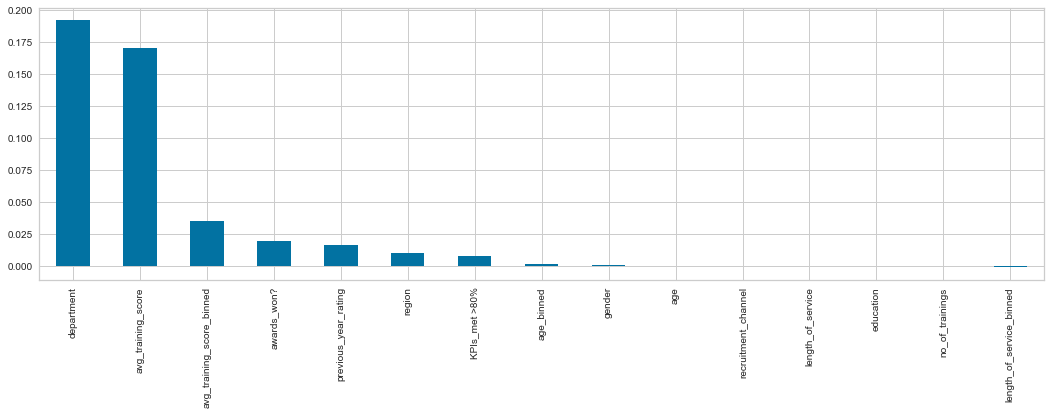

In [202]:
pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

In [203]:
sel.features_to_drop_

['region',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'age_binned',
 'length_of_service_binned']

In [204]:
X_trainx = sel.transform(X_train_enc)
X_testx = sel.transform(X_test_enc)

X_trainx.shape, X_testx.shape

((28774, 3), (12332, 3))

In [205]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_trainx, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.584 total time=   4.0s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [206]:
pred_probs = model4.predict_proba(X_testx)[:,1]
scores = print_results('Random Shuffle', y_test, model4.predict(X_testx), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496
9,SFS-Forward,0.839848,534.0,1459.0,9823.0,516.0,0.267938,0.508571,0.846603,0.420597,0.629812,0.431132


In [207]:
from feature_engine.selection import RecursiveFeatureAddition

In [210]:
rfa = RecursiveFeatureAddition(
    variables=None, # automatically examine all numerical variables
    estimator=LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5), # the ML model
    scoring='f1_macro', # the metric to evaluate
    threshold=0.001,# the maximum performance drop allowed to select the feature
    cv=2)

rfa.fit(X_train_enc, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_

RecursiveFeatureAddition(cv=2,
                         estimator=LGBMClassifier(boosting_type='dart',
                                                  class_weight={0: 0.9, 1: 0.1},
                                                  colsample_bytree=0.5,
                                                  lambda_l1=0.1, lambda_l2=5,
                                                  learning_rate=0.03,
                                                  max_bin=100000,
                                                  min_data_in_leaf=30,
                                                  n_estimators=1000,
                                                  num_leaves=30,
                                                  random_state=42,
                                                  subsample=0.6),
                         scoring='f1_macro', threshold=0.001)

In [211]:
rfa.initial_model_performance_

0.7298725782693845

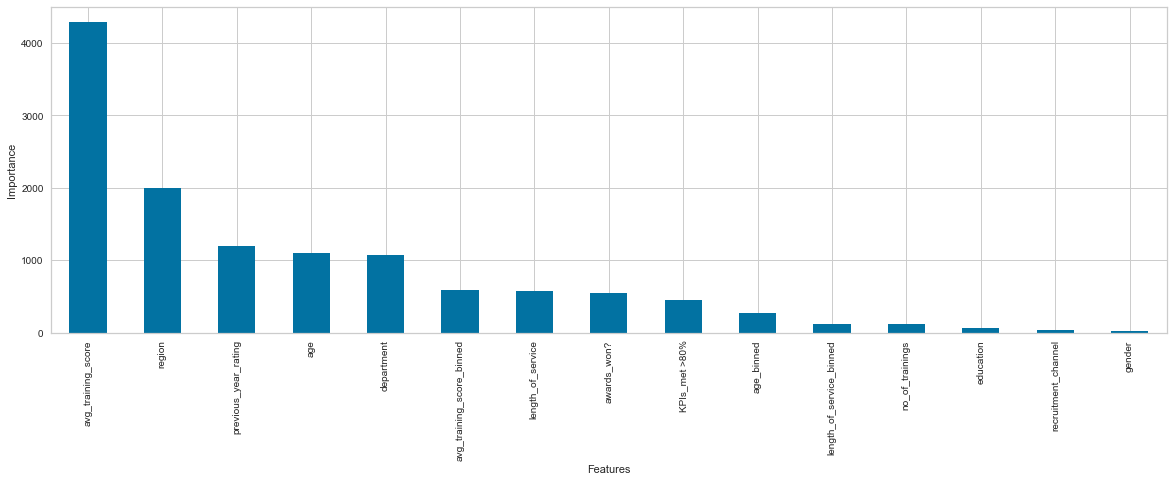

In [212]:
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

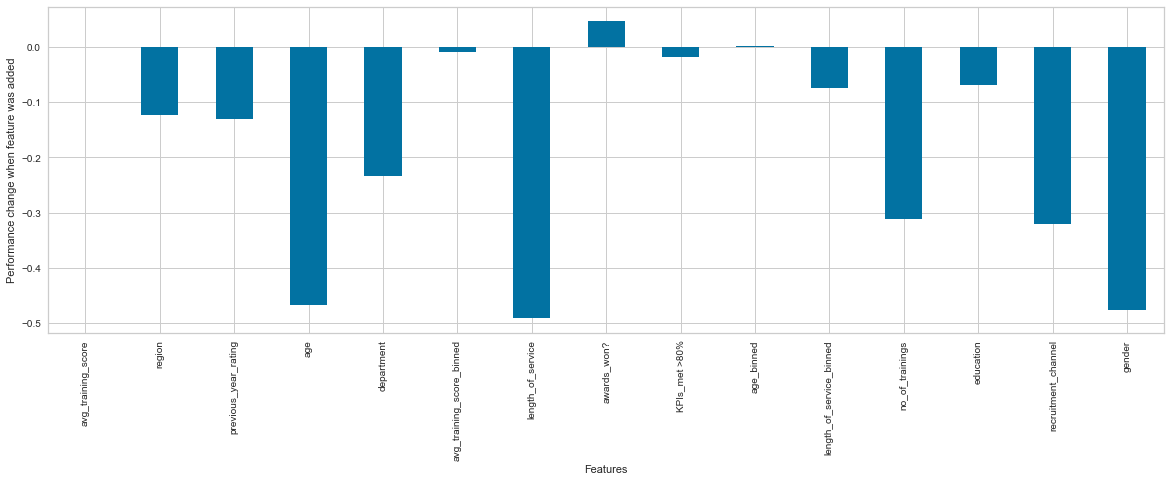

In [213]:
pd.Series(rfa.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [214]:
rfa.features_to_drop_

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'length_of_service_binned',
 'avg_training_score_binned']

In [215]:
X_trainx = rfa.transform(X_train_enc)
X_testx = rfa.transform(X_test_enc)

X_trainx.shape, X_testx.shape

((28774, 3), (12332, 3))

In [216]:
pipeline = Pipeline([('classifier' , LGBMClassifier(random_state=42,
                                                    boosting_type = "dart",
                                                    class_weight = {0:0.90 , 1:0.10},
                                                    n_estimators = 1000,
                                                    subsample = 0.6,
                                                    num_leaves = 30,
                                                    min_data_in_leaf = 30,
                                                    max_bin = 100000,
                                                    learning_rate = 0.03,
                                                    lambda_l2 = 5,
                                                    lambda_l1 = 0.1,
                                                    colsample_bytree = 0.5))])

params = [{'classifier__max_depth':[2]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="f1_macro")
           
model4 = grid4.fit(X_trainx, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 1/2; 1/1] END ......classifier__max_depth=2;, score=0.599 total time=   3.9s
[CV 2/2; 1/1] START classifier__max_depth=2.....................................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[CV 2/2; 1/1] END ......classifier__max_depth=2;

In [217]:
pred_probs = model4.predict_proba(X_testx)[:,1]
scores = print_results('RFA', y_test, model4.predict(X_testx), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
modelcomparison = pd.concat([modelcomparison, dftmp], ignore_index=True)
modelcomparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1_macro,f2
0,Model-1,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
1,Model-2-Basics,0.707428,931.0,3489.0,7793.0,119.0,0.210633,0.886667,0.865029,0.469941,0.576213,0.540023
2,Model-2-Basics,0.812520,741.0,2003.0,9279.0,309.0,0.270044,0.705714,0.877516,0.532759,0.639918,0.533554
3,Model-3-Anova,0.924019,305.0,192.0,11090.0,745.0,0.613682,0.290476,0.862155,0.476855,0.676889,0.324675
4,Model-4-Univariate,0.690723,942.0,3706.0,7576.0,108.0,0.202668,0.897143,0.854778,0.460350,0.564773,0.532324
5,Model-4-Univariate-FE,0.923451,110.0,4.0,11278.0,940.0,0.964912,0.104762,0.685192,0.326654,0.574417,0.127492
6,Model-5-Bins+TargetMean,0.554817,784.0,5224.0,6058.0,266.0,0.130493,0.746667,0.723129,0.314360,0.455167,0.384013
7,Model-6-TargetMean,0.925803,224.0,89.0,11193.0,826.0,0.715655,0.213333,0.858480,0.441698,0.644709,0.248172
8,Model-6-TargetMean+binsTargetMean,0.927749,223.0,64.0,11218.0,827.0,0.777003,0.212381,0.865047,0.455000,0.647693,0.248496
9,SFS-Forward,0.839848,534.0,1459.0,9823.0,516.0,0.267938,0.508571,0.846603,0.420597,0.629812,0.431132
